# Housing Values in Suburbs of Boston

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive [link](http://lib.stat.cmu.edu/datasets/boston). Also available in scikit-learn built in datasets.

## Objective: 
Train a regression model for medv (Median value of owner-occupied homes in $1000's)

### Data description

The Boston data frame has 506 rows and 14 columns.
This data frame contains the following columns:

* crim: per capita crime rate by town.
* zn: proportion of residential land zoned for lots over 25,000 sq.ft.
* indus: proportion of non-retail business acres per town.
* chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
* nox: nitrogen oxides concentration (parts per 10 million).
* rm: average number of rooms per dwelling.
* age: proportion of owner-occupied units built prior to 1940.
* dis: weighted mean of distances to five Boston employment centres.
* rad: index of accessibility to radial highways.
* tax: full-value property-tax rate per \$10,000.
* ptratio: pupil-teacher ratio by town.
* black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
* lstat: lower status of the population (percent).
* medv: median value of owner-occupied homes in \$1000s.

### Note
Variable 14 seems to be censored at 50.00, corresponding to a median price of `$50,000`.

Censoring is suggested by the fact that the highest median price of exactly `$50,000`
is reported in 16 cases, while 15 cases have prices between `$40,000` and `$50,000`, with prices rounded to the nearest hundred. Harrison and Rubinfeld do not mention any censoring.


### Sources

Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

In [22]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

# Set plotting style
plt.style.use('ggplot')

In [11]:
boston = pd.read_csv('train.csv')

In [12]:
# Examine data
boston.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [13]:
# Drop ID column, not needed
boston.drop('ID', axis=1, inplace=True)

In [14]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [16]:
# Creating feature and target arrays
X = boston.drop('medv', axis=1).values
y = boston['medv'].values

As a first task, let's try to predict the price from a single feature: the average number of rooms

In [19]:
X_rooms = X[:, 5]
type(X_rooms), type(y)

(numpy.ndarray, numpy.ndarray)

In [20]:
# Turn into NumPy arrays of desired shape
# Keep first dimension, but add another dimension of size 1 to X
y = y.reshape(-1, 1)
X_rooms = X_rooms.reshape(-1, 1)

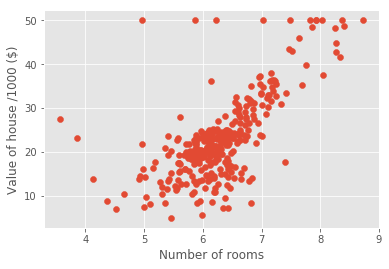

In [21]:
# Plotting house value vs. number of rooms
plt.scatter(X_rooms, y)
plt.ylabel('Value of house /1000 ($)')
plt.xlabel('Number of rooms')
plt.show()

In [23]:
# Instantiate Linear Regression
reg = linear_model.LinearRegression()

In [24]:
reg.fit(X_rooms, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

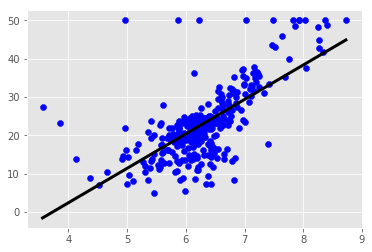

In [26]:
# Fitting a regression model
prediction_space = np.linspace(min(X_rooms),
                               max(X_rooms)).reshape(-1, 1)
plt.scatter(X_rooms, y, color='blue')
plt.plot(prediction_space, reg.predict(prediction_space),
         color='black', linewidth=3)
plt.show()